# Viewing SVAR as causal structural model

Notebook on how SVAR based with short-run exclusion restriction can be viewed as a structural causal model (SCM).

Notebok by @VilleEcon.

TO DO:
 - Someting wrong with producing the result with adjustment formula... 

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as sm_form
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.moment_helpers import corr2cov
np.random.seed(5000)

import rpy2
%load_ext rpy2.ipython

In [2]:
%%R
library(dagitty)

## Generate data for the example

Let $\{y_{i, t} \}_{t=0}^{T-1}$ (notice index start at $t=0$!) denote a one-dimensional time series of length $T$ sampled for each random variable $Y_{i}$. Less verbosely, we'll usually just write $y_{i,t}$ to denote the i*th* time series or variable, depending on context. A collection of N time series $\{y_{1, t}, ... , y_{N, t} \}_{t=0}^{T-1}$ can be written as $y_t$, $t=0,...,T-1$. Each $y_t$ is thus a $1xN$ vector. Let $N=2$ so that we have two time series $y_{1,t}$ and $y_{2,t}$.

We assume the true data genrating process (DGP) is

$$
\begin{align*}
y_{t} & = \begin{bmatrix} \rho y_{2,t} \\ 0 \end{bmatrix} + \beta y_{t-1} + \gamma o_{t}
\end{align*}
$$

where

$
\begin{align*}
y_t = \begin{bmatrix} y_{1,t} \\ y_{2,t} \end{bmatrix}
\end{align*}
$, $
\begin{align*}
o_t = \begin{bmatrix} o_{1,t} \\ o_{2,t} \end{bmatrix}
\end{align*}
$, $
\begin{align*}
\beta = \begin{bmatrix} 0.8 & 0.05 \\ -0.5 & 0.7 \end{bmatrix}
\end{align*}
$, $
\begin{align*}
\gamma = \begin{bmatrix} 1 & 0 \\ 0 & 1\end{bmatrix}
\end{align*}
$, and $\rho = -0.2$.

$u_t$ is multivariate normal with assumed means 0 and standard deviations 1, and further assumed that shocks are not correlated, meaning correlation matrix

$
\begin{align*}
\mathbf{\Sigma}_u = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
\end{align*}
$.

,y1,y2
0,0.017856,-0.851545
1,1.233069,-0.353082


,y1,y2
998,-0.155544,1.164093
999,2.187971,1.861772


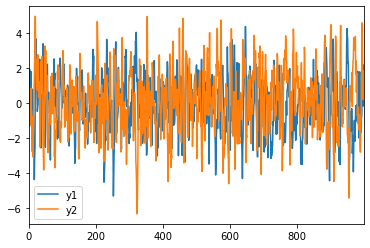

In [3]:
# Number of observations and intial state
no_obs = 1000
no_presample = 200
initial_state = np.array([[0, 0]])

# Generate array of u's
o_means = [0 ,0]
o_stds = [1, 1]
corrmat = [
    [1, 0],
    [0, 1],
]
covmat = corr2cov(corrmat, o_stds)
o_array = np.random.multivariate_normal(
    mean=o_means,
    cov=covmat,
    size=no_obs+no_presample-1
)

# Allocate array for data, with initial values plugged in
data_array = np.empty([no_obs+no_presample, 2])
data_array[:] = np.nan
data_array[0:1, :] = initial_state

# coefficient arrays
beta1 = np.array([
       [0.8, 0.05], 
       [-0.5, 0.7],
])

gamma = np.array([
       [1, 0], 
       [0, 1],
])
rho = 0.2

# Simulate data
for i in range(1, no_obs+no_presample):
    data_array[i, :] = (np.matmul(beta1, data_array[i-1, :, np.newaxis]) + 
                        np.matmul(gamma, o_array[i-1, :, np.newaxis])).T
    
    # extra rho*y_2 term for y_1
    data_array[i, :] = data_array[i, :] + np.array([rho * data_array[i, 1], 0])

df = pd.DataFrame(data_array[no_presample:, :], columns=["y1", "y2"])
_ = df.plot()
display(df.head(2))
display(df.tail(2))

## Motivation - SVAR impulse responses

In economics we are often interested in the so-called **impulse response** of one variable, say $y_1,t$, on shock to some other varibale, say $y_{2,t}$. Loosely speaking, inpulse response at period $h = 0, 1, \cdots$ can be defined as

$$E\big[\frac{\partial y_{1,t+h}}{\partial \omega_{2,t}}\big]$$

where $\omega_{2,t}$ is an unanticipated "shock" to variable $y_{2,t}$. Note that in general SVAR shocks do *not* correspond to particular model variable, but in the case when (short-run) exclusion restrictions are being used for SVAR identification this interpetation can be made.

In this notebook we will demonstrate how the contemporaneous ($h=0$) impulse response $E\big[\frac{\partial y_{1,t}}{\partial \omega_{2,t}}\big]$ can be formulated in the language of more general causal inference litrature and structural causal models.

## Structural causal model (SCM)

To begin with, assume that we are intrested in the expected value of $y_{1,t}$ given that we, by intervention, set the value of $y_{2,t}$ to $v$, that is $do(y_{2,t} = v)$. Generally without using a particular value in fixing  we just write $do(y_{2,t})$. We could compare this to the expected value of $y_{1,t}$ given we *observed* value of $y_{2,t}$ as being, say, $v*$ (again we refrainn from writing the observed value explicitly). Mathematically the difference os these two values is

$$E[y_{1,t} \ | \ do(y_{2,t})] - E[y_{1,t} \ | \ y_{2,t}].$$

Above $E[y_{1,t} \ | \ y_{2,t}]$ is a typical *statistical estimand* but $E[y_{1,t} \ | \ do(y_{2,t})]$, involving the do-operator, is a *causal estimand*. What the expressions descibes is exactly the definition of contemporaneous (structural) impulse response of $y_1,t$ on $y_{2,t}$ we saw above, ie. what is the expected contemporanoues response of $y_{1,t}$ to an unexpected change (intervention) in $y_{2,t}$. We could hence go as far as defining the strucural shock as

$$\omega_{2,t} \equiv do(y_{2,t} = v) - (y_{2,t}=v*).$$

Again, this defintion erlies on fact that in SVAR we use exclusion restrictions.

In order to proceed with calculating the expression of interest we assume the following SCM for our two variables:

$$
\begin{align}
y_{1,t} &= f_1(y_{2,t}, y_{1,t-1}, y_{2,t-1}, \epsilon_{1,t}) \\
y_{2,t} &= f_1(y_{1,t-1}, y_{2,t-1}, \epsilon_{2,t})
\end{align}
$$

This corresponds to following DAG:

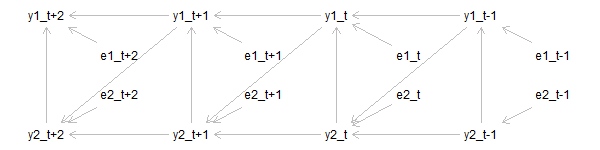

In [4]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t+2" [pos="0,1"]
    "y2_t+2" [pos="0,4"]
    "e1_t+2" [pos="1,2"]
    "e2_t+2" [pos="1,3"]
    "y1_t+1" [pos="2,1"]
    "y2_t+1" [pos="2,4"]
    "e1_t+1" [pos="3,2"]
    "e2_t+1" [pos="3,3"]
    "y1_t"   [pos="4,1"]
    "y2_t"   [pos="4,4"]
    "e1_t"   [pos="5,2"]
    "e2_t"   [pos="5,3"]
    "y1_t-1" [pos="6,1"]
    "y2_t-1" [pos="6,4"]
    "e1_t-1" [pos="7,2"]
    "e2_t-1" [pos="7,3"]    
    "y1_t+2" <- "y1_t+1" <- "y1_t" <- "y1_t-1"
    "y2_t+2" <- "y2_t+1" <- "y2_t" <- "y2_t-1"
    "y1_t+2" <- "e1_t+2"
    "y1_t+1" <- "e1_t+1"
    "y1_t"   <- "e1_t"
    "y1_t-1" <- "e1_t-1"
    "y2_t+2" <- "e2_t+2"
    "y2_t+1" <- "e2_t+1"
    "y2_t"   <- "e2_t"
    "y2_t-1" <- "e2_t-1"
    "y2_t+2" <- "y1_t+1"
    "y2_t+1" <- "y1_t"
    "y2_t"   <- "y1_t-1"
    "y1_t+2" <- "y2_t+2"
    "y1_t+1" <- "y2_t+1"
    "y1_t" <- "y2_t"
    "y1_t-1" <- "y2_t-1"            
}')
plot(g)

Given the SCM, we want to be able to *identify* the causal estimand from above. This means writing this estimand in purely distributional terms, without the do-operator. If we can do this, then we have two statistical estimands which, assuming some functional form and estimation technique, can be estimated.

$$
\begin{align}
E_{y_{1,t} | do(y_{2,t})} \ [y_{1,t} \ | \ do(y_{2,t})] &= E_{y_{t-1}} \ \big[E_{y_{1,t} | do(y_{2,t})} \ [y_{1,t} \ | \ do(y_{2,t}), \ y_{t-1} ] \big] \quad & \text{Law of iter. expec.} \\
&= E_{y_{t-1}} \  \big[E_{y_{1,t} | y_{2,t}} \ [ y_{1,t} | \ y_{2,t}, \ y_{t-1} ] \big]  \quad & \text{unconfoundedness based on SCM} \\
\end{align}
$$

Resulting conditional adjustment is called **adjustment formula**, as it has "adjusted" for confounders and turned causal estimad into a statistical estimand.

For what follows, assume further we are willing to give the SCM a linear structure. Then

$$
\begin{align}
y_{1,t} &= &d_{0, 12} y_{2,t} + d_{1, 11} y_{1,t-1} + d_{1, 12} y_{2,t-1} + \epsilon_{1,t} \\
y_{2,t} &= &d_{1, 21} y_{1,t-1} + d_{1, 22} y_{2,t-1} + \epsilon_{2,t} \\
\end{align}
$$

In vector notation

$$
\begin{align*}
D_0 y_{t} & =  D_1 y_{t-1} + \epsilon_{t}
\end{align*}
$$

where $
\begin{align*}
D_0 = \begin{bmatrix} 1 & -d_{0,12} \\ 0 & 1 \end{bmatrix}
\end{align*}
$ and
$
\begin{align*}
D_1 = \begin{bmatrix} d_{1,11} & d_{1,12} \\ d_{1,21} & d_{1,22} \end{bmatrix}
\end{align*}
$. Now our SCM corresponds exactly to the DGP with $\epsilon = o$, $D_1 = \beta$ and $d_{0,12} = \rho$.

## Direct estimation using the derived adjustment formula

We are interested in estimateing the value of adjustment formula derived above. In order to do this we need to evaluate the two expectations appearing in the equation. For $E_{y_{1,t} | y_{2,t}} \ [ y_{1,t} | \ y_{2,t}, \ y_{t-1} ]$ we will use a linear regression as we assumed a linear structure for the SCM. On the other hand, $E_{y_{t-1}} (\cdot)$ can be evaluated as a simple average over all possible values of $y_{t-1}$. As we will see, evaluating both expectations separately is rather cubersome. Fortunately there is a much more straightforward way to get the same result which we'll utilize in next section.

See section 2.5 of Neal (2020): *Introduction to Causal Inference*.

In [5]:
# Prepare data for OLS
gg = df.copy()
gg["y1_l1"] = gg["y1"].shift(1)
gg["y2_l1"] = gg["y2"].shift(1)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y1 ~ y2 + y1_l1 + y2_l1 -1", data=gg.dropna()).fit()

In [6]:
## CANT GET THIS RIGHT, maybe not enough values??
#
## We cannot loop over ALL unique values of y1_l1 and y2_l1 as there are too many combinations
## instead, create random sample; this is very slow still!
#y1lag1vals = np.random.choice(gg["y1_l1"].unique(), 20)
#y2lag1vals = np.random.choice(gg["y2_l1"].unique(), 20)
#
#predictions = []
#for y1val in y1lag1vals:
#    for y2val in y2lag1vals:
#        hh = gg.copy()
#        hh["y1_l1"] = y1val
#        hh["y2_l1"] = y2val
#        predictions.append(ols_res.predict(hh[["y2", "y1_l1", "y2_l1"]]))
#
#np.mean(predictions)

## Direct estimation from SCM model regression equation

We can skip the above nonsense by relying on some statistical decision theory. We have that, in our linear case, the an estimate for $E_{y_{t-1}} \  \big[E_{y_{1,t} | y_{2,t}} \ [ y_{1,t} | \ y_{2,t}, \ y_{t-1} ] \big]$ can be read of as the coefficient estimate for $y_{2,t}$ from linear regression $y_{1,t} \sim y_{2,t} + y_{1,t-1} + y_{2,t-1}$. Why? This has to do with the fact that $g(x) = E(Y|X=x)$ is the solution for problem $min_{g(x)} \ E(Y - g(X))^2$ and since minimizing squared residuals yields conditional expectation. Some references for this:
 - [Finding a function minimizing the expected value](https://stats.stackexchange.com/a/358488/162538)
 - Hastie et al (2017, 10th printing): *Elements of statistical learning*, section 2.4
 - Neal (2020): *Introduction to Causal Inference*, section 2.5.

In [7]:
print(ols_res.summary())
print("Estimate for y2 is: {:.3f}, true value (rho) is {}".format(ols_res.params["y2"], rho))

                                 OLS Regression Results                                
Dep. Variable:                     y1   R-squared (uncentered):                   0.574
Model:                            OLS   Adj. R-squared (uncentered):              0.573
Method:                 Least Squares   F-statistic:                              447.6
Date:                Sat, 05 Dec 2020   Prob (F-statistic):                   4.53e-184
Time:                        16:04:06   Log-Likelihood:                         -1417.1
No. Observations:                 999   AIC:                                      2840.
Df Residuals:                     996   BIC:                                      2855.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Interpreting SCM as (S)VAR

Recall the SCM from above. This equation looks a lot like a following SVAR model with recursice short-run identification scheme:

$$
\begin{align*}
B_0 y_{t} & =  B_1 y_{t-1} + \omega_{t}
\end{align*}
$$

where

$
\begin{align*}
B_0 = \begin{bmatrix} 1 & b_{0,12} \\ 0 & 1 \end{bmatrix}
\end{align*}
$, and
$
\begin{align*}
B_1 = \begin{bmatrix} b_{1,11} & b_{1,12} \\ b_{1,21} & b_{1,22} \end{bmatrix}
\end{align*}
$

In reduced form:
$$
\begin{align*}
& y_{t} =  B_0 B_1 y_{t-1} + B_0 \omega_{t} \\
\iff & y_{t} =  A_1 y_{t-1} + u_{t}
\end{align*}
$$

DAG for SVAR looks as follos. Notice that it is equivalent to the DAG of SCM; the only thing that is different is that arrow $y_{2,t} \rightarrow y_{2,t}$ has dissapreared since there is an arrow $\omega_2 \rightarrow y_{1,t}$. This is to say that (S)VAR there are no causal arrows between contemporanoues variables, but rather that these variables can have a common "shock". As long as the SVAR identification scheme is recursice short-run identification, these results coincide.

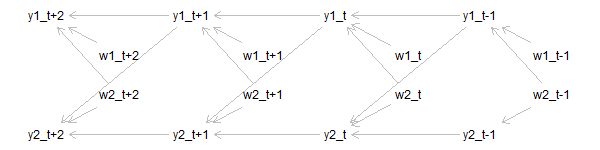

In [8]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t+2" [pos="0,1"]
    "y2_t+2" [pos="0,4"]
    "w1_t+2" [pos="1,2"]
    "w2_t+2" [pos="1,3"]
    "y1_t+1" [pos="2,1"]
    "y2_t+1" [pos="2,4"]
    "w1_t+1" [pos="3,2"]
    "w2_t+1" [pos="3,3"]
    "y1_t"   [pos="4,1"]
    "y2_t"   [pos="4,4"]
    "w1_t"   [pos="5,2"]
    "w2_t"   [pos="5,3"]
    "y1_t-1" [pos="6,1"]
    "y2_t-1" [pos="6,4"]
    "w1_t-1" [pos="7,2"]
    "w2_t-1" [pos="7,3"]    
    "y1_t+2" <- "y1_t+1" <- "y1_t" <- "y1_t-1"
    "y2_t+2" <- "y2_t+1" <- "y2_t" <- "y2_t-1"
    "y1_t+2" <- "w1_t+2"
    "y1_t+1" <- "w1_t+1"
    "y1_t"   <- "w1_t"
    "y1_t-1" <- "w1_t-1"
    "y2_t+2" <- "w2_t+2" -> "y1_t+2"
    "y2_t+1" <- "w2_t+1" -> "y1_t+1"
    "y2_t"   <- "w2_t" -> "y1_t"
    "y2_t-1" <- "w2_t-1" -> "y1_t-1"
    "y2_t+2" <- "y1_t+1"
    "y2_t+1" <- "y1_t"
    "y2_t"   <- "y1_t-1"
}')
plot(g)

Fit (S)VAR model

In [9]:
# VAR
model_var = sm.tsa.VAR(df)
res_var = model_var.fit(maxlags=1)
irf_var = res_var.irf(5)

# SVAR
D = np.asarray([
    ["E", "E"],
    [0, "E"],
])
model_svar = sm.tsa.SVAR(df, svar_type='A', A=D)
res_svar = model_svar.fit(maxlags=1)
irf_svar = res_svar.irf(5) 

In [10]:
res_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Dec, 2020
Time:                     16:04:07
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0634190
Nobs:                     999.000    HQIC:                 0.0451502
Log likelihood:          -2846.00    FPE:                    1.03453
AIC:                    0.0339490    Det(Omega_mle):         1.02835
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.034628         0.032387           -1.069           0.285
L1.y1         0.725257         0.021201           34.208           0.000
L1.y2         0.202487         0.017894           11.316           0.000

Results for equation 

Display impulse reponses. As we can see, immediate impulse response of $y_{1,t}$ on $\omega_{2,t}$ is as expected.

Estimated effect of w2_t on y1_t is about 0.21, while true value (rho) is 0.2

Full structural impact multiplier matrix


,0,1
0,1.000497,0.206205
1,0.000000,1.013568


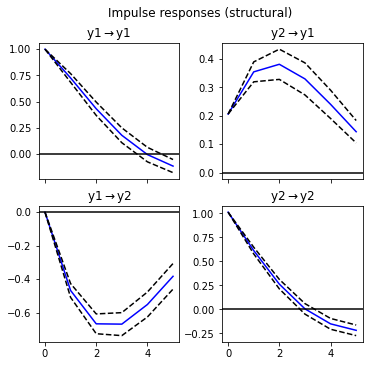

In [11]:
fig = irf_svar.plot()
fig.suptitle(fig._suptitle.get_text(), fontsize=12)
fig.set_size_inches(5, 5)
plt.subplots_adjust(top=0.88, wspace=0.3)
_, _, ax, _ = fig.get_axes()
print("Estimated effect of w2_t on y1_t is about {:.2f}, while true value (rho) is {}".format(irf_svar.svar_irfs[0, 0, 1], 0.2))
print("")
print("Full structural impact multiplier matrix")
display(pd.DataFrame(np.linalg.inv(res_svar.A)))